# Load packages, data, and define functions
### Load required packages

In [1]:
# Requirements

import scipy.io as sio #
import tensorflow as tf #
import numpy as np #
import keras
from keras.models import Sequential
from keras.initializers import glorot_normal
from keras.layers import Dense, Dropout
import keras.backend as K
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt #
%matplotlib inline
import csv
import scipy.stats
import os

Using TensorFlow backend.


### User inputs

In [2]:
# Flag if 3D, frontal, or sagittal
modeltype = '3D' # Options are '3D' 'frontal' or 'sagittal'
    
# Configure to use CPU or GPU 
# 'GPU' : 1 if you are using a GPU, 0 otherwise
config = tf.ConfigProto(device_count = {'CPU' : 1, 'GPU' : 1})
session = tf.Session(config=config)
K.set_session(session)

### Define functions for later in script

In [21]:
def r2_numpy(data,labels,model):
    y_pred2 = model.predict(data)
    mse = np.mean(np.square(y_pred2-labels))
    r2 = np.square(np.corrcoef(labels.T,y_pred2.T)[0,1])
    mae = np.mean(np.abs(y_pred2-labels))
    return r2,mse,mae

def PredictKAM(model,inputData):
    predictedKAM = model.predict(inputData[range(inputData.shape[0]),:])
    return predictedKAM

def PlotKAMpredictions(trueKAM,predictedKAM):
    # Plot predicted and true peaks vs. step
    plt.figure(1)
    truePlot = plt.plot(trueKAM)
    predPlot = plt.plot(predictedKAM)
    plt.ylabel('KAM Peak Comparison')
    plt.xlabel('Step')
    plt.legend(('True','Predicted'),loc=4);

    # Plot predicted vs. true peaks
    plt.figure(2)
    ax = plt.plot(trueKAM,predictedKAM,'.',color=(45/255, 107/255, 179/255),alpha=0.05)
    plt.axis('equal')
    plt.ylabel('Predicted KAM')
    plt.xlabel('True KAM')
    plt.ylim(0,7)
    plt.xlim(0,7)
    plt.plot([-1,7],[-1,7],'k')
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
def PlotTrainingCurves(trainResults,devResults,epochCount):
    # Plot training curves
    lossPlt = plt.plot(np.arange(1,epochCount+1),train_loss[range(epochCount)])
    DevlossPlt = plt.plot(np.arange(1,epochCount+1),dev_loss[range(epochCount)])

    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch Number');
    plt.legend(('Training','Dev'))

    plt.figure(2)
    r2Plt = plt.plot(np.arange(1,epochCount+1),train_r2[range(epochCount)])
    devr2Plt = plt.plot(np.arange(1,epochCount+1),dev_r2[range(epochCount)])
    plt.ylim([.5, 1])
    plt.ylabel('r^2')
    plt.xlabel('Epoch Number');
    plt.legend(('Training','Dev'))
    
if modeltype not in ['3D', 'frontal', 'sagittal']:
    raise ValueError("Error: Options are '3D' 'frontal' or 'sagittal'.")

### Load the data

In [4]:
# Load input data dictionary
inputData = np.load("Data\inputData.npy").flat[0]

# Marker Positions 
markerPos = inputData["markers"]

# Height (per step)
height = inputData["height"]

# Weight (per step)
weight = inputData["weight"]

# Leg (per step)
leg = inputData["leg"]

# Subject Number (per step)
subind = inputData["subjectStepInds"]

# First Knee Adduction Moment Peak (per step)
KAM = inputData["KAM"]

### Format input, normalize marker positions, and use first half of stance

In [5]:
# Adjust input to correct format
markers = np.moveaxis(markerPos, [0,1,2], [2,1,0]) # nSamples x nTimesteps x nFeatures
weightMat = np.expand_dims(weight,axis=2)
heightMat = np.expand_dims(height,axis=2)
legBin = np.expand_dims(leg,axis=2)

# Normalize positions by height
markersNorm = np.divide(markers,heightMat)

# Input based on model
if modeltype == '3D':
    inputMat = np.concatenate((markersNorm, legBin),axis = 2) # add leg to markers
if modeltype == 'frontal':
    inputMat = np.concatenate((markersNorm[:,:,range(1,39,3)],markersNorm[:,:,range(2,39,3)], legBin),axis = 2)  
if modeltype == 'sagittal':
    inputMat = np.concatenate((markersNorm[:,:,range(0,39,3)],markersNorm[:,:,range(2,39,3)], legBin),axis = 2)
    
# Use positions from first half of stance
firstHalfStance = range(0,16,2)
inputMat = inputMat[:,firstHalfStance,:] # nSamples x nTimesteps x nFeatures
print("Input shape is " + str(inputMat.shape))

Input shape is (112730, 8, 40)


### Format output, normalize KAM, find peak KAM

Output shape is (112730, 1, 1)


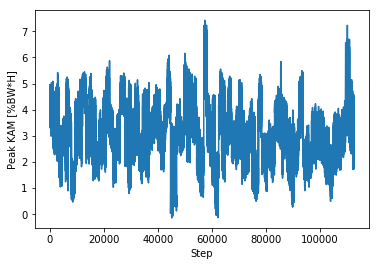

In [6]:
# Reshape the output
KAMreshape = KAM.reshape((-1,30,1)) 

# Normalize KAM data by height and weight (gives units of BW*H)
KAMnorm = np.divide(KAMreshape,np.multiply(weightMat.reshape(-1,30,1),heightMat.reshape(-1,30,1))) * 100

# Find peak KAM
KAMP1 = np.max(KAMnorm[:,range(15),:],axis=1)
output = KAMP1.reshape((-1,1,1))
print("Output shape is " + str(output.shape))

plt.plot(output[:,0,0]);
plt.ylabel("Peak KAM [%BW*H]");
plt.xlabel("Step");

### Divide into train, development, and test sets

In [7]:
# Set seed for repeatable results
np.random.seed(0)

# Load the random subject split from the paper
subFile = np.load("Data\subjectSplit.npy")
subSplit = subFile.flat[0]
trainNums = subSplit["trainNums"]
devNums = subSplit["devNums"]
testNums = subSplit["testNums"]

# Find step indicies for each subject in each set
trainInds = np.array(0)
for i in trainNums:
    trainInds = np.append(trainInds,np.argwhere(subind==i))
trainInds = trainInds[1:]
    
devInds = np.array(0)
for i in devNums:
    devInds = np.append(devInds,np.argwhere(subind==i))
devInds = devInds[1:]

testInds = np.array(0)
for i in testNums:
    testInds = np.append(testInds,np.argwhere(subind==i))
testInds = testInds[1:]

# Build training, development, and test inputs and labels
trainInput_full = inputMat[trainInds,:,:]
trainInput_full = trainInput_full.reshape((trainInput_full.shape[0],-1))
trainLabels = output[trainInds,0]

devInput_full = inputMat[devInds,:,:]
devInput_full = devInput_full.reshape((devInput_full.shape[0],-1))
devLabels = output[devInds,0]

testInput_full = inputMat[testInds,:,:]
testInput_full = testInput_full.reshape((testInput_full.shape[0],-1))
testLabels = output[testInds,0]


### Remove redundant leg inputs, and if 3D model, remove lasso features

In [8]:
if modeltype == '3D':
    # features removed by the lasso (saved from R)
    lassoDeletedInds = inputData["lassoDeletedInds3D"]
    
    #Positions to remove - every 40th index is leg. Leave the first one
    inputIndicies = np.delete(np.arange(0,320),np.unique(np.concatenate((np.arange(79,320,40),lassoDeletedInds))))
    
elif np.logical_or(modeltype == 'frontal',modeltype=='sagittal'):
    #Positions to remove - every 28th index is leg. Leave the first one
    inputIndicies = np.delete(np.arange(0,216),np.arange(53,216,27))

# Remove input features
trainInput = trainInput_full[:,inputIndicies]
devInput = devInput_full[:,inputIndicies]
testInput = testInput_full[:,inputIndicies]

# Use pre-trained weights predict KAM (from model presented in manuscript)
Note that results may vary slightly from the paper for several reasons: <br />
1) The models in the paper were trained with a GPU, results vary slightly when trained with CPU <br />
2) Small floating-point differences when we re-packaged dataset for distribution <br />
3) For test set results, we randomly sample 400 steps from each leg in the set (to mitigate the effect of walking speed or stride frequency on outcome metrics), while the results here are for all steps in the test set. We also bootstrap resampled the test set 10,000 times to compute the mean and confidence intervals of performance metrics, making the mean performance metric vary slightly from the results on the uniformly-sampled test set here.

r2 = 0.8002699224150202, MSE = 0.45073372601232725, MAE = 0.555317741596472


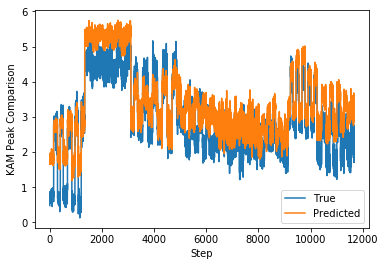

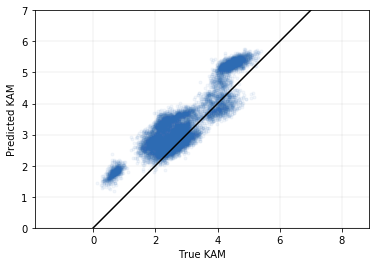

In [9]:
# Import previously trained model and weights for prediction
json_file = open("PretrainedModels/NeuralNet_" + modeltype + ".json", 'r')
pretrainedModel_json = json_file.read()
json_file.close()
pretrainedModel = keras.models.model_from_json(pretrainedModel_json)
# load weights into new model
pretrainedModel.load_weights("PretrainedModels/NeuralNet_" + modeltype + "_weights.h5")
pretrainedModel.compile(loss='mean_squared_error',optimizer='adam')
 
# evaluate loaded model on test data
testPredictions_pretrainedModel = PredictKAM(pretrainedModel,testInput)

# Plot predicted vs true KAM predictions
PlotKAMpredictions(testLabels,testPredictions_pretrainedModel)

# Print test r2 and MSE
test_r2 = r2_numpy(testInput,testLabels,pretrainedModel)
print('r2 = ' + str(test_r2[0]) + ', MSE = ' + str(test_r2[1])+ ', MAE = ' + str(test_r2[2]))

# Train new model from scratch
### Construct new model

In [10]:
train_r2 = np.empty((1000,1))
dev_r2 = np.empty((1000,1))
train_loss = np.empty((1000,1))
dev_loss = np.empty((1000,1))
epochCount = 0 ;

def construct_model(nHiddenUnits, nHiddenLayers, input_dim, output_dim):
    np.random.seed(1)
    tf.set_random_seed(1)

    model = Sequential()
    model.add(Dense(800,input_shape = (input_dim,), kernel_initializer=glorot_normal(seed=None) , activation='relu')) #,kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01)))
    for i in range(nHiddenLayers-1):
        model.add(Dropout(0.01))
        model.add(Dense(nHiddenUnits , kernel_initializer=glorot_normal(seed=None) , activation='relu')) #,kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01)))
    
    model.add(Dropout(0.01))
    model.add(Dense(1,kernel_initializer=glorot_normal(seed=None),activation='linear'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

model = construct_model(nHiddenUnits = 100, nHiddenLayers = 1, input_dim = trainInput.shape[1], output_dim = trainLabels.shape[1])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               240000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 801       
Total params: 240,801
Trainable params: 240,801
Non-trainable params: 0
_________________________________________________________________


### Train model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 800)               240000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 801       
Total params: 240,801
Trainable params: 240,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1 of 30.
Epoch 1/1
 - 7s - loss: 0.5201
Train_loss = [0.32911794], Train_r2 = [0.71210582], Dev_loss = [0.7517395], Dev_r2 = [0.70530731]
saving best model
Epoch 2 of 30.
Epoch 1/1
 - 6s - loss: 0.2900
Train_loss = [0.23147889], Train_r2 = [0.7691148], Dev_loss = [0.48798079], Dev_r2 = [0.70448874]
saving best model
Epoch 3 of 30.
Epoch 1/1
 - 6s - loss: 0.2400
Train_loss = [0.18617831], Tra

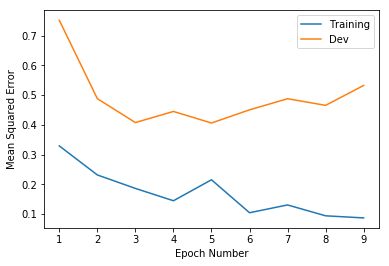

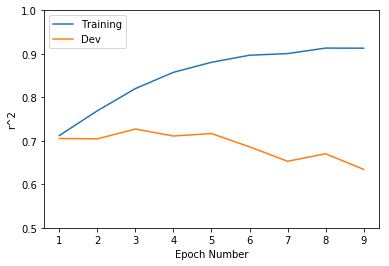

In [23]:
nEpochs = 30
models = [] ;


train_r2 = np.zeros((1000,1))
dev_r2 = np.zeros((1000,1))
train_loss = np.zeros((1000,1))
dev_loss = np.zeros((1000,1))
train_mae = np.zeros((1000,1))
dev_mae = np.zeros((1000,1))
epochCount = 0 ;

thisModel = construct_model(nHiddenUnits = 100, nHiddenLayers = 1, input_dim = trainInput.shape[1], output_dim = trainLabels.shape[1])
thisModel.summary()

for i in range(nEpochs):
    print('Epoch ' + str(i+1) + ' of ' + str(nEpochs) + '.')

    history = thisModel.fit(trainInput,trainLabels, epochs=1 , batch_size = 32, shuffle = True, verbose=2)

    train_r2[epochCount], train_loss[epochCount], train_mae[epochCount] = r2_numpy(trainInput,trainLabels,thisModel)
    dev_r2[epochCount], dev_loss[epochCount], dev_mae[epochCount] = r2_numpy(devInput,devLabels,thisModel)
    print('Train_loss = ' + str(train_loss[epochCount]) + ', Train_r2 = ' + str(train_r2[epochCount]) + ', Dev_loss = ' + str(dev_loss[epochCount]) + ', Dev_r2 = ' + str(dev_r2[epochCount]))

    devBest = np.argmin(dev_loss[dev_loss !=0])
    if i-devBest > 4: # stop training if dev hasn't gotten better in last 5 epochs
        print('No Longer Improving')
        break
        
    if i == devBest:
        model = keras.models.clone_model(thisModel)
        model.set_weights(thisModel.get_weights())
        print('saving best model')

    epochCount = epochCount + 1 ;
            
bestEpoch = np.argmin(dev_loss[dev_loss !=0])
print('For Best Epoch:' + str(bestEpoch+1) + ' Train r2 =' + str(train_r2[bestEpoch]) + ' Dev r2 =' + str(dev_r2[bestEpoch]))

# Plot training curves
PlotTrainingCurves(train_r2,dev_r2,epochCount)

### Save newly trained model

In [12]:
# Make directory for newly trained models
if not os.path.isdir('NewlyTrainedModels'):
    os.mkdir('NewlyTrainedModels')

# Serialize model to JSON
model_json = model.to_json()
with open("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel_weights.h5")
print("Saved model to disk")

Saved model to disk


### Evaluate Predictions
Note that results may vary slightly from the paper for several reasons: <br />
1) The models in the paper were trained with a GPU, results vary slightly when trained with CPU <br />
2) Small floating-point differences when we re-packaged dataset for distribution <br />
3) For test set results, we randomly sample 400 steps from each leg in the set (to mitigate the effect of walking speed or stride frequency on outcome metrics), while the results here are for all steps in the test set. We also bootstrap resampled the test set 10,000 times to compute the mean and confidence intervals of performance metrics, making the mean performance metric vary slightly from the results on the uniformly-sampled test set here.

r2 = 0.8002699224150202, MSE = 0.45073372601232725, MAE = 0.555317741596472


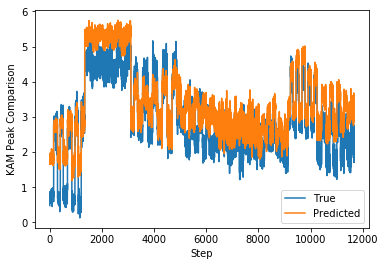

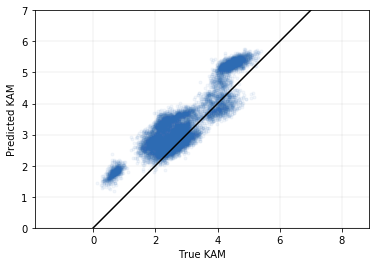

In [13]:
# Evaluate model performance on one of the data splits
# Change BOTH INPUT AND LABELS for data split that you'd like to use for model evaluation
inputForEval = testInput # options: trainInput, devInput, testInput
labelsForEval = testLabels # options: trainLabels, devLabels, testLabels

# Only after model hyperparameter tuning was finished, we evaluated on test set
predictionsForEval = PredictKAM(model,inputForEval)

# Plot predicted vs true KAM predictions
PlotKAMpredictions(labelsForEval,predictionsForEval)

# Print performance metrics
evaluatedMetrics = r2_numpy(inputForEval,labelsForEval,model)
print('r2 = ' + str(evaluatedMetrics[0]) + ', MSE = ' + str(evaluatedMetrics[1])+ ', MAE = ' + str(evaluatedMetrics[2]))